# **PRIPREMA OKRUZENJA (Colab specifically)**

In [1]:
!pip install optuna

In [2]:
!pip install --upgrade tensorflow

In [3]:
!pip install -U "ray[tune,train]"

In [4]:
!pip install git+https://github.com/jdb78/lipo.git

  Cloning https://github.com/jdb78/lipo.git to /tmp/pip-req-build-jdj9wnd9
  Running command git clone --filter=blob:none --quiet https://github.com/jdb78/lipo.git /tmp/pip-req-build-jdj9wnd9
  Resolved https://github.com/jdb78/lipo.git to commit faa5b122beab5c4ffda2f1509ef6b761f6633d56
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
#all the important stuff:
#offloads pandas work to cuDF, acccelerates work with (supported) Ngreedia GPUs
#%load_ext cudf.pandas
#didnt work due to conflicts with pandas-expected behaviour when interacting with stuff like seaborn. good try tho, left it in for posterity
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display

#magic function for interactive plots within the notebook
%matplotlib inline

#removing size limit to prevent truncation
pd.options.display.max_columns = None

#neccesary for multiple regression analysis - tests high correlation of independent variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

#im lazy
import warnings
warnings.filterwarnings("ignore")

#regression prereqs
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from scipy import stats

#LIPO+RF
#importing LIPOSearchCV wrapper
from lipo.hyperparameter import LIPOSearchCV

#TPE+SVR
import optuna
from optuna.trial import Trial
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler # Using RobustScaler for outlier resilience
from sklearn.model_selection import KFold, cross_val_score

#DE+XGBoost
from scipy.optimize import differential_evolution
import xgboost as xgb
from xgboost import XGBRegressor

#GODZILLA
import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ray
from ray import tune
from ray.train.tensorflow import TensorflowTrainer
from ray.train import ScalingConfig
from ray.tune.integration.keras import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler

In [6]:
#file uploader independent of gdrive
from google.colab import files

#check if the CSV file is already in local storage (cached)
if os.path.exists("starcraft_player_data.csv"):
    print("Loading cached starcraft_player_data.csv from local storage...")
    sc2df = pd.read_csv("starcraft_player_data.csv")
else:
    print("File not found in local storage. Please upload 'starcraft_player_data.csv'.")
    uploaded = files.upload() #upload window popup
    #uploaded file is automatically stored in current working directory
    sc2df = pd.read_csv(io.BytesIO(uploaded['starcraft_player_data.csv']))

Loading cached starcraft_player_data.csv from local storage...


In [7]:
#sanity check
sc2df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [8]:
sc2df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3395 non-null   object 
 3   HoursPerWeek          3395 non-null   object 
 4   TotalHours            3395 non-null   object 
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

In [9]:
sc2df.describe()

,GameID,LeagueIndex,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4805.012371,4.184094,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,2719.944851,1.517327,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,52.000000,1.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2464.500000,3.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4874.000000,4.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,7108.500000,5.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
max,10095.000000,8.000000,389.831400,0.043088,0.001752,10.000000,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [10]:
print("\nOutlier Analysis using a 3×IQR rule:\n")

# Check each numeric feature for outliers
for col in sc2df.select_dtypes(include=['number']).columns:
    Q1 = sc2df[col].quantile(0.25)
    Q3 = sc2df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = sc2df[(sc2df[col] < lower_bound) | (sc2df[col] > upper_bound)]
    outlier_count = outliers.shape[0]

    print(f"Column: {col}")
    print(f"  Q1: {Q1:.3f}, Median: {sc2df[col].median():.3f}, Q3: {Q3:.3f}")
    print(f"  IQR: {IQR:.3f}")
    print(f"  Lower Bound: {lower_bound:.3f}, Upper Bound: {upper_bound:.3f}")
    print(f"  Number of Outliers: {outlier_count}\n")


Outlier Analysis using a 3×IQR rule:

Column: GameID
  Q1: 2464.500, Median: 4874.000, Q3: 7108.500
  IQR: 4644.000
  Lower Bound: -11467.500, Upper Bound: 21040.500
  Number of Outliers: 0

Column: LeagueIndex
  Q1: 3.000, Median: 4.000, Q3: 5.000
  IQR: 2.000
  Lower Bound: -3.000, Upper Bound: 11.000
  Number of Outliers: 0

Column: APM
  Q1: 79.900, Median: 108.010, Q3: 142.790
  IQR: 62.890
  Lower Bound: -108.770, Upper Bound: 331.461
  Number of Outliers: 11

Column: SelectByHotkeys
  Q1: 0.001, Median: 0.002, Q3: 0.005
  IQR: 0.004
  Lower Bound: -0.010, Upper Bound: 0.017
  Number of Outliers: 134

Column: AssignToHotkeys
  Q1: 0.000, Median: 0.000, Q3: 0.000
  IQR: 0.000
  Lower Bound: -0.001, Upper Bound: 0.001
  Number of Outliers: 9

Column: UniqueHotkeys
  Q1: 3.000, Median: 4.000, Q3: 6.000
  IQR: 3.000
  Lower Bound: -6.000, Upper Bound: 15.000
  Number of Outliers: 0

Column: MinimapAttacks
  Q1: 0.000, Median: 0.000, Q3: 0.000
  IQR: 0.000
  Lower Bound: -0.000, Uppe

# **PRIPREMA ZADATKA (must run)**

tokom rucnog pregleda .csv fajla u MS Excel-u pronadjeno je nekoliko polja u nekoliko kolona sa "?" vrednostima. Sledecih desetak celija se koristi za input sanitization da ostatak funkcionise kako treba:

In [11]:
#osnova besramno ukradena sa bezgranicnih pasnjaka interneta, rucno doradjeno za potrebe zadatka
def missing_val_check(data):

  #pretvaranje "?" u NaN
  data.replace("?", np.nan, inplace=True)

  #provera missing data
  total = data.isnull().sum().sort_values(ascending=False)
  percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent * 100], axis=1, keys=["Total", "Percent(%)"])
  return missing_data

In [12]:
missing_report = missing_val_check(sc2df)
display(missing_report)
sc2df = sc2df.replace("?", np.nan)
sc2df = sc2df.apply(pd.to_numeric, errors='ignore')

,Total,Percent(%)
TotalHours,57,1.678940
HoursPerWeek,56,1.649485
Age,55,1.620029
LeagueIndex,0,0.000000
GameID,0,0.000000
APM,0,0.000000
SelectByHotkeys,0,0.000000
AssignToHotkeys,0,0.000000
UniqueHotkeys,0,0.000000
MinimapAttacks,0,0.000000


In [13]:
sc2df[sc2df["Age"].isnull()]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3340,10001,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.000000
3341,10005,8,NaN,NaN,NaN,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.000000
3342,10006,8,NaN,NaN,NaN,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.000000
3343,10015,8,NaN,NaN,NaN,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.000000
3344,10016,8,NaN,NaN,NaN,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.000000
3345,10017,8,NaN,NaN,NaN,245.8188,0.010471,0.000841,10,0.000657,0.001314,0.005031,14.5518,36.7134,7.1943,33,0.001474,11,0.000040,0.000048
3346,10018,8,NaN,NaN,NaN,211.0722,0.013049,0.000940,10,0.000366,0.000909,0.003719,19.6169,38.9326,7.1320,23,0.000898,9,0.000000,0.000000
3347,10021,8,NaN,NaN,NaN,189.5778,0.007559,0.000487,10,0.000606,0.000566,0.005821,22.0317,36.7330,4.9050,28,0.000540,5,0.000000,0.000000
3348,10022,8,NaN,NaN,NaN,210.5088,0.007974,0.000867,7,0.000548,0.000638,0.006518,15.7856,30.7156,4.8058,34,0.000817,6,0.000000,0.000000
3349,10023,8,NaN,NaN,NaN,248.0118,0.014722,0.001752,7,0.000375,0.000110,0.004115,17.4656,34.2357,7.8973,20,0.001111,8,0.000000,0.000000


iz ovoga se vidi da su svi "Age" NaN igraci iz League Index-a 8. Popunicemo nedostojece podatke u skladu sa tendencijama ostatka csv-a, koje proveravamo na sledeci nacin:

<Axes: xlabel='LeagueIndex', ylabel='Age'>

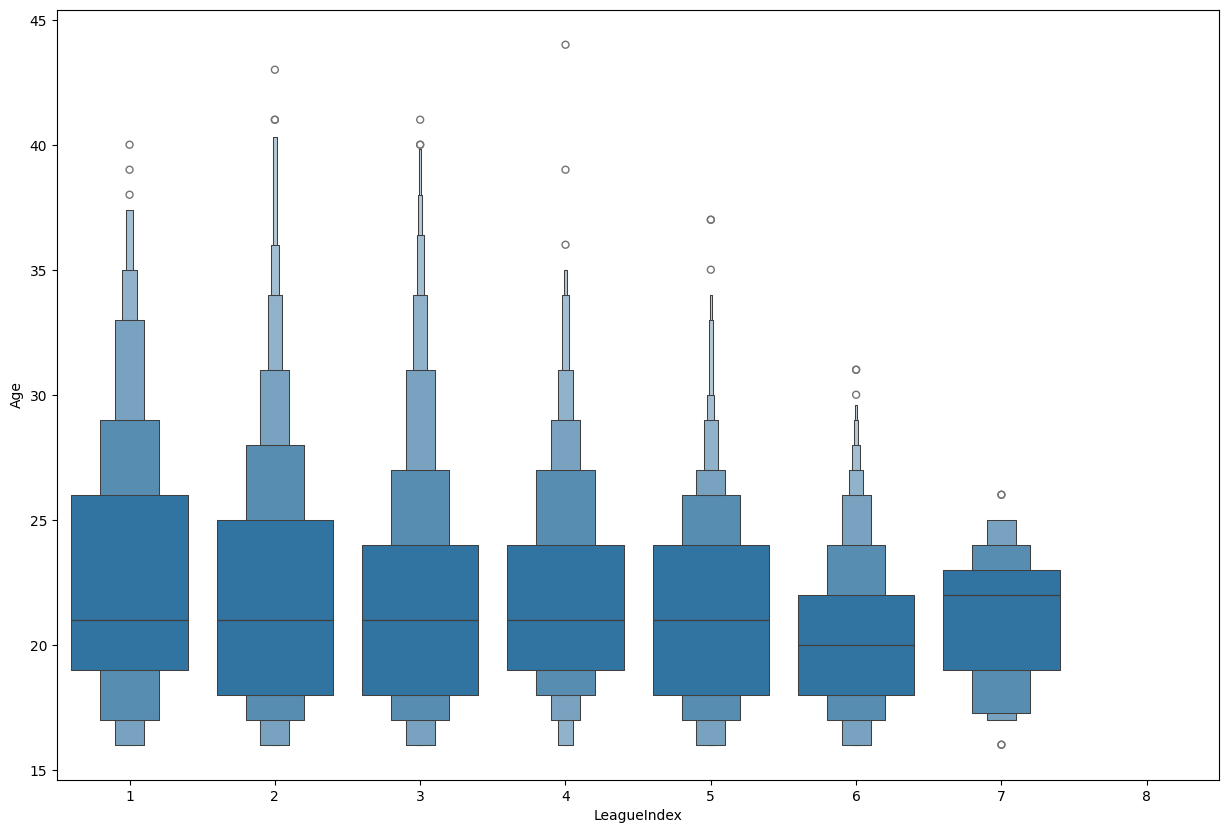

In [14]:
plt.figure(figsize=(15, 10))
sns.boxenplot(data=sc2df, x="LeagueIndex", y="Age", k_depth="trustworthy")
#note to self: trustworthy je parametar za dinamicku kontrolu broja boxova u prikazu u odnosu na raspodelu vrednosti. koristi se za mix preciznosti i citljivosti

In [15]:
#vidimo da sto je visi rank, to su mladji igraci (makes sense), stoga ce se NaN vrednosti osmice popuniti sa medijanom sedmice
med_val = sc2df[sc2df["LeagueIndex"] == 7]["Age"].median()
sc2df["Age"] = sc2df["Age"].fillna(med_val)

In [16]:
#provera koji league bracket igraci imaju NaN "HoursPerWeek", ostalo sve kao iznad
sc2df[sc2df["HoursPerWeek"].isnull()]["LeagueIndex"].unique()

array([5, 8])

<Axes: xlabel='LeagueIndex', ylabel='HoursPerWeek'>

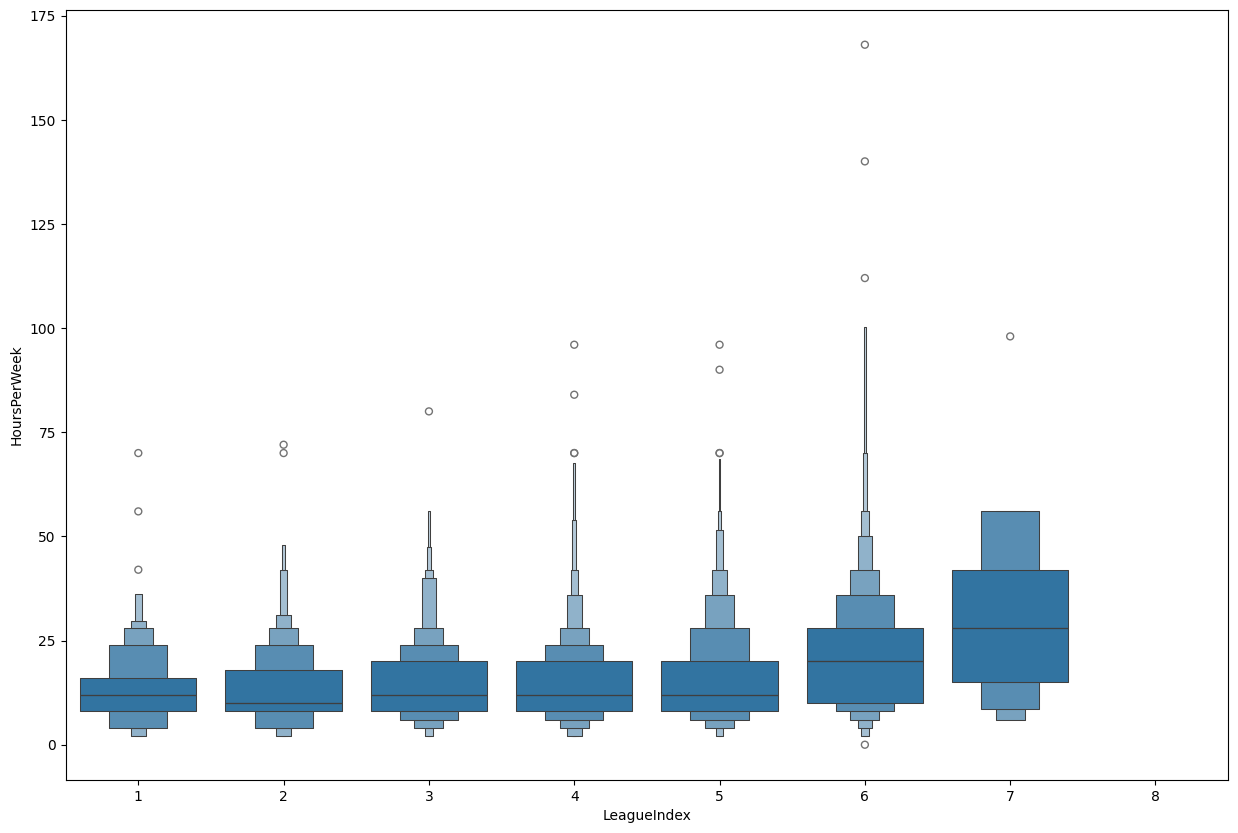

In [17]:
plt.figure(figsize=(15, 10))
sns.boxenplot(data=sc2df, x="LeagueIndex", y="HoursPerWeek", k_depth="trustworthy")

In [18]:
#za LBracket5
med_val_l5 = sc2df[sc2df["LeagueIndex"] == 5]["HoursPerWeek"].median()
sc2df.loc[
    (sc2df["HoursPerWeek"].isnull()) & (sc2df["LeagueIndex"] == 5), "HoursPerWeek"
] = med_val_l5

#za LBracket8 (opet medijan sedmice)
med_val_l8 = sc2df[sc2df["LeagueIndex"] == 7]["HoursPerWeek"].median()
sc2df.loc[
    (sc2df["HoursPerWeek"].isnull()) & (sc2df["LeagueIndex"] == 8), "HoursPerWeek"
] = med_val_l8

In [19]:
#repete za "TotalHours" NaN
sc2df[sc2df["TotalHours"].isnull()]["LeagueIndex"].unique()

array([5, 8])

<Axes: xlabel='LeagueIndex', ylabel='TotalHours'>

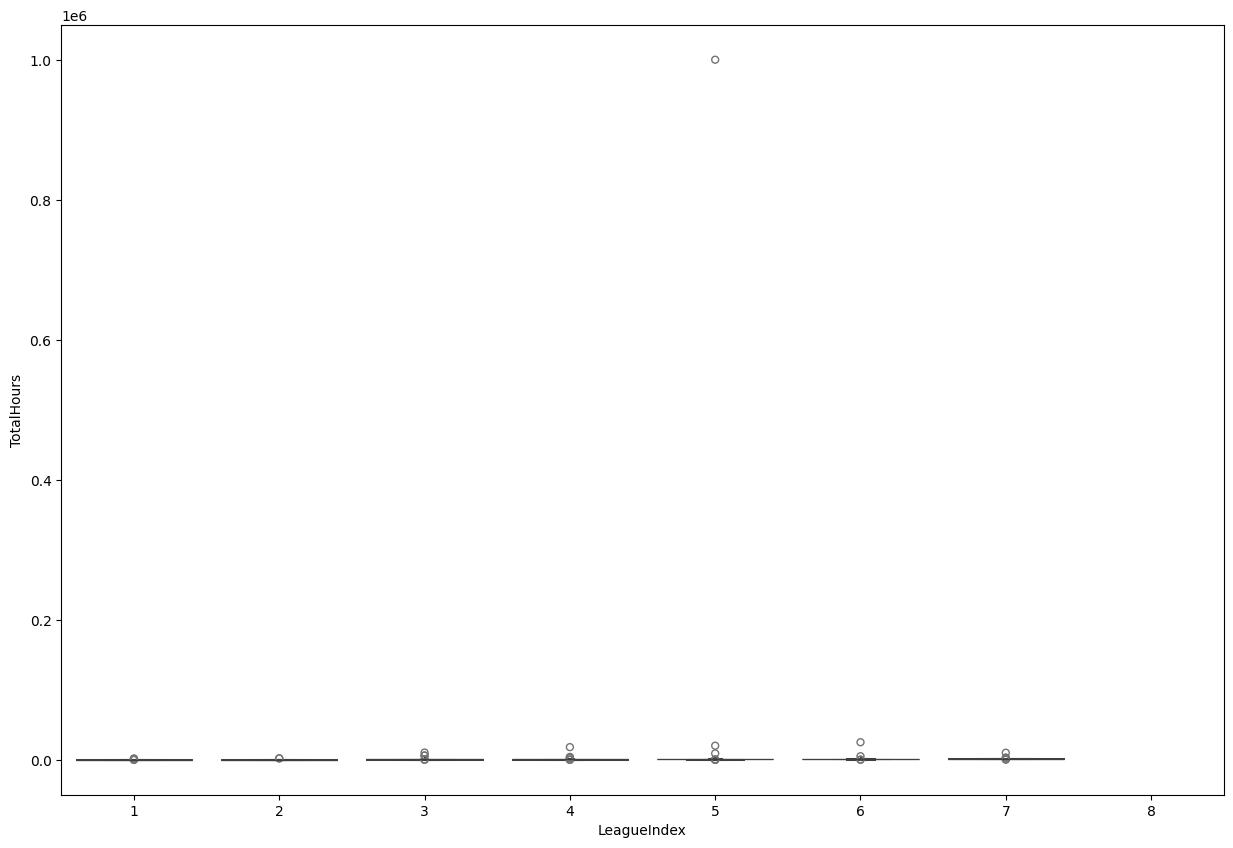

In [20]:
plt.figure(figsize=(15, 10))
sns.boxenplot(data=sc2df, x="LeagueIndex", y="TotalHours", k_depth="trustworthy")

*(facepalm)*.....now what?

In [21]:
#usled nedostatka vidljivih trendova, koristicu medijane 5, 6 i 7

med_val_l6l7 = sc2df[sc2df["LeagueIndex"].between(5, 7)]["TotalHours"].median()
sc2df.loc[sc2df["TotalHours"].isnull(), "TotalHours"] = med_val_l6l7

In [22]:
print("Total missing values now are {}".format(sc2df.isnull().sum().sum()))

Total missing values now are 0


*(cheers & confetti)*

hipoteticki gledano, da ovaj set podataka bude iskoriscen za masinsko ucenje, mora se ukloniti potencijalna multikolinearnost (da bi se umanjio interval poverenja tj povecala preciznost rezultata prilikom promene pojedinacnih promenljivih) (note to self: sunshine/heat --> summer ice cream sales thing)

<Axes: >

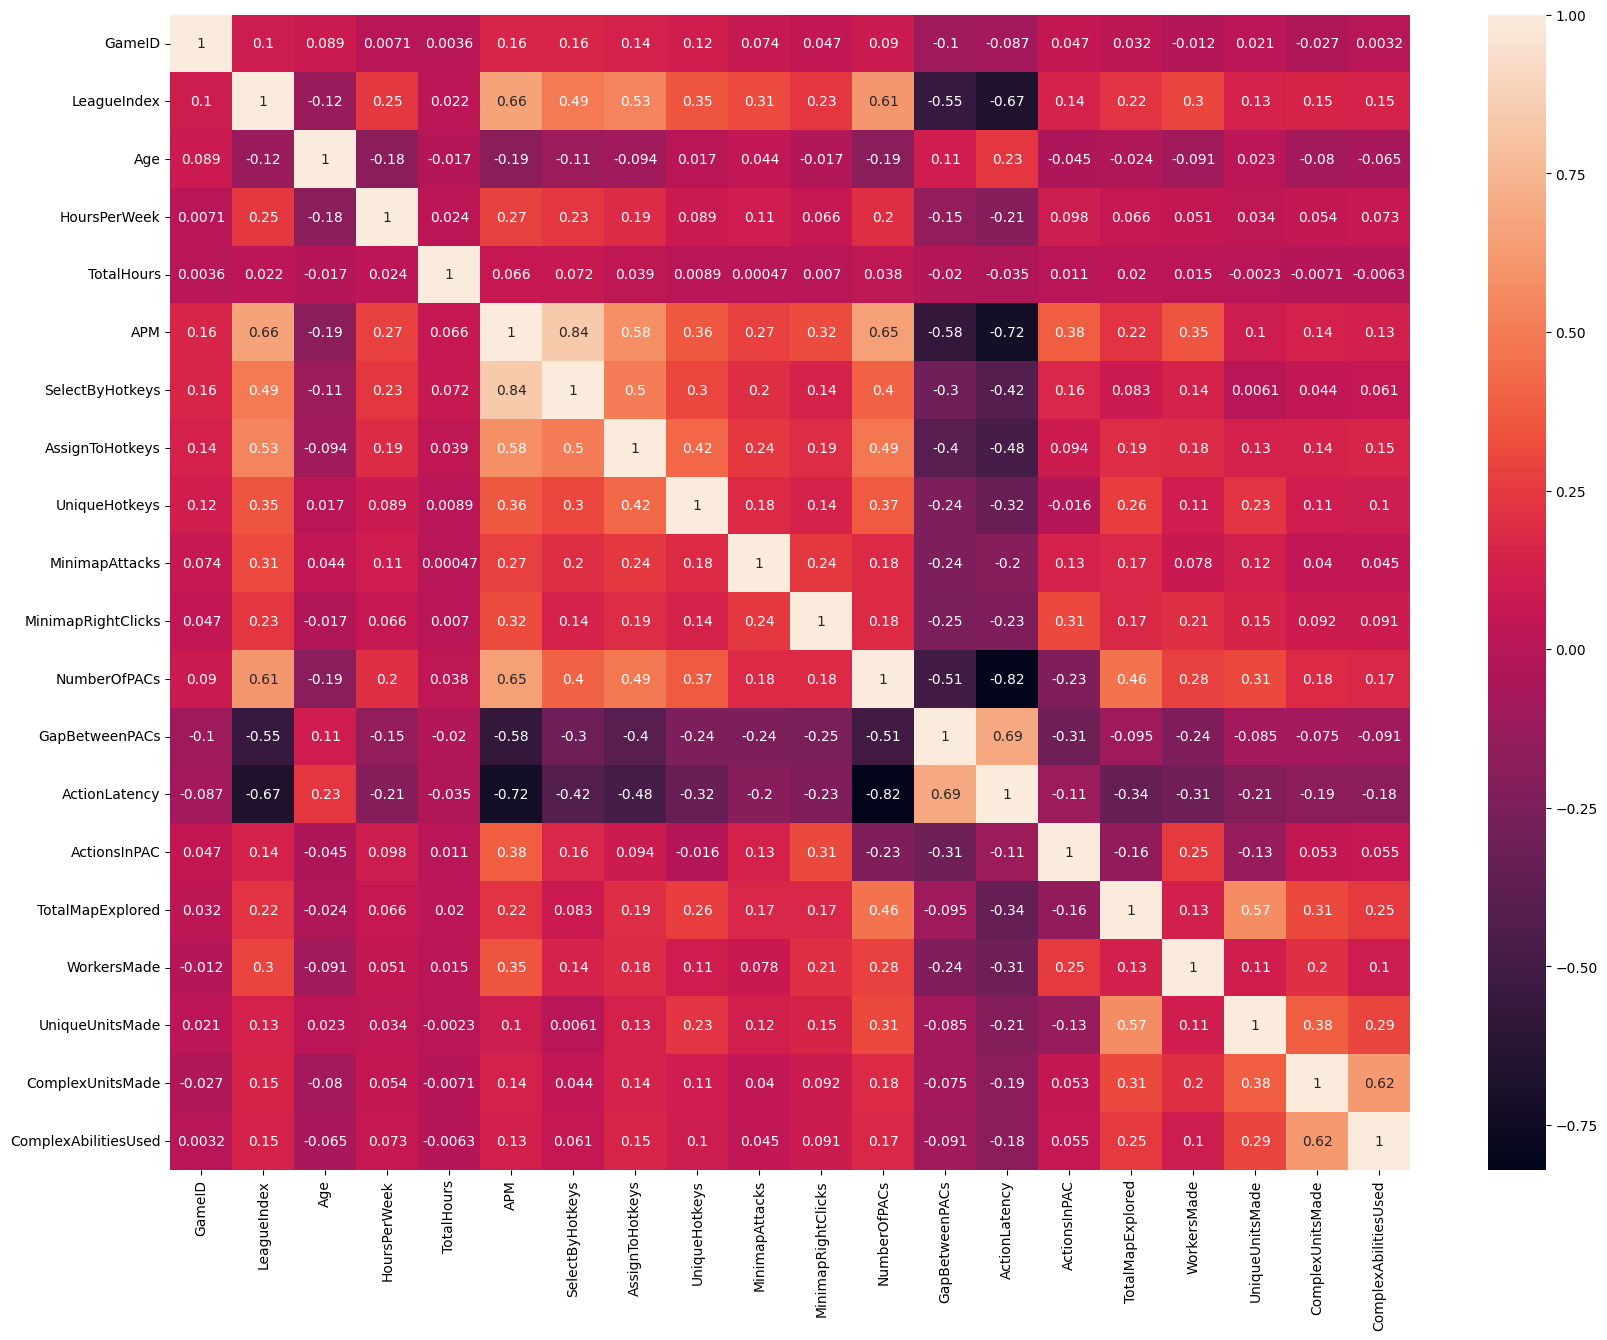

In [23]:
plt.figure(figsize=(20, 15))
corr = sc2df.corr()
sns.heatmap(corr, annot=True)

(note to self: generalno gledano, koeficijenti >0.5 && <-0.5 su "visoka multikolinearnost")

s obzirom na to da je prvenstveno bitan LeagueIndex (jer je najbitnije da li si sampion ili nisi, jelte) on se uzima kao target i na osnovu tj izuzimajuci njega se meri VIF:

In [24]:
sc2df_indpt = sc2df.drop(["LeagueIndex"], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = sc2df_indpt.columns

#izracunavanje za svaku kolonu pojedinacno
vif_data["VIF"] = [
    variance_inflation_factor(sc2df_indpt.values, i)
    for i in range(len(sc2df_indpt.columns))
]
vif_data

,feature,VIF
0,GameID,4.344851
1,Age,29.854517
2,HoursPerWeek,3.132604
3,TotalHours,1.009870
4,APM,232.194927
5,SelectByHotkeys,23.234204
6,AssignToHotkeys,6.501246
7,UniqueHotkeys,5.906430
8,MinimapAttacks,1.579504
9,MinimapRightClicks,2.637366


(note to self: VIF>10 pokazuje na multikolinearnost medju promenljivim koje zahtevaju temeljne provere i uklanjanje)

da bi dalje statisticke metode bile merodavne, malo cemo pocistiti dataset uklanjajuci najmanje vazne kolone

In [25]:
#uklonicemo ActionsInPAC (Perception Action Cycle) i UniqueUnitsMade, vidi se na heatmap-i da su slabo povezane sa targetom ali imaju visok VIF, kao i SelectByHotkeys zbog AssignToHotkeys
sc2df_indpt = sc2df.drop(
    ["LeagueIndex", "ActionsInPAC", "UniqueUnitsMade", "SelectByHotkeys"], axis=1
)
# _indpt jer je novi dataframe za nezavisne promenljive koriscene kasnije
vif_data = pd.DataFrame()
vif_data["feature"] = sc2df_indpt.columns

#ponovna provera VIF-a nad novim dataframe-om
vif_data["VIF"] = [
    variance_inflation_factor(sc2df_indpt.values, i)
    for i in range(len(sc2df_indpt.columns))
]
vif_data.sort_values(["VIF"], ascending=False)

,feature,VIF
9,NumberOfPACs,28.636404
1,Age,27.771423
11,ActionLatency,26.639711
4,APM,15.935097
12,TotalMapExplored,14.776361
10,GapBetweenPACs,14.038617
5,AssignToHotkeys,6.376048
13,WorkersMade,5.878592
6,UniqueHotkeys,5.839591
0,GameID,4.340230


<Axes: >

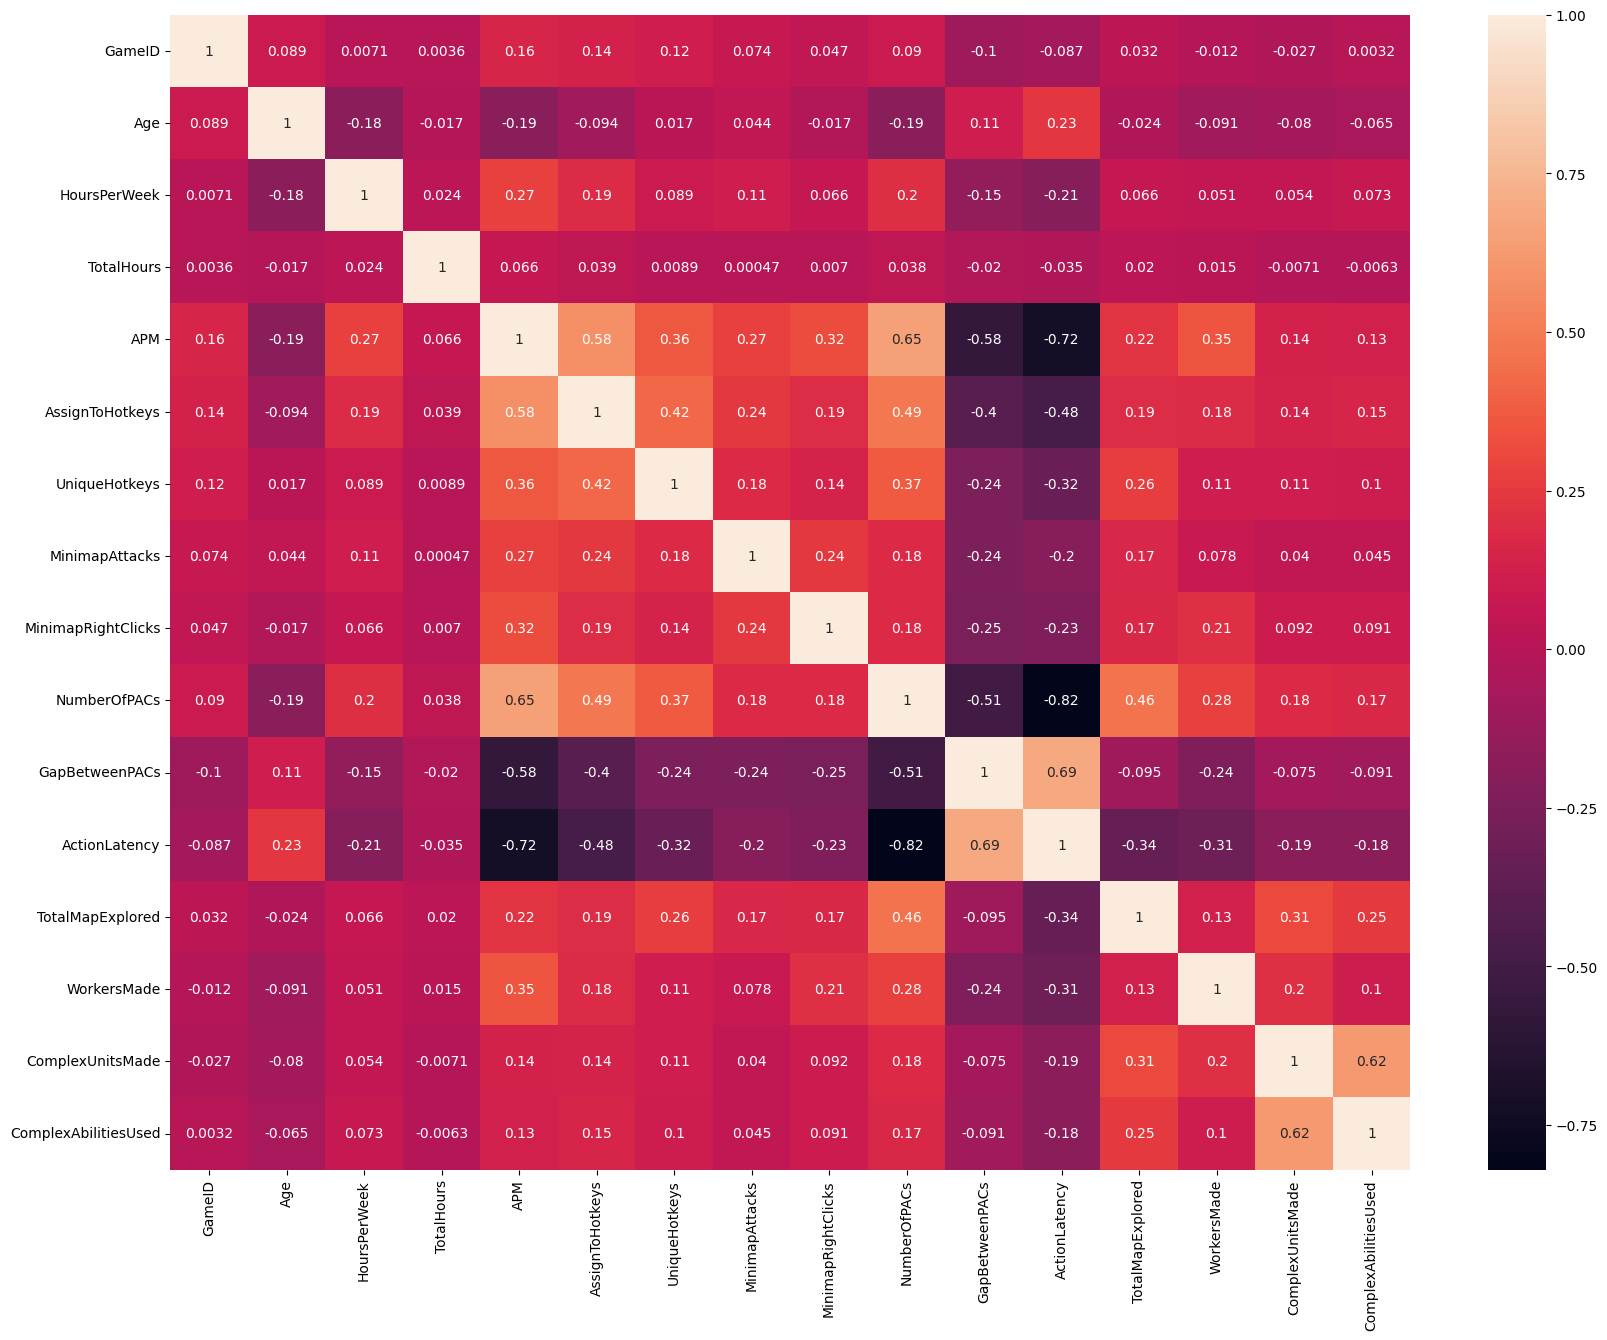

In [26]:
#provera multikolinearnosti, take 2
plt.figure(figsize=(20, 15))
corr = sc2df_indpt.corr()
sns.heatmap(corr, annot=True)

In [27]:
#NumberOfPACs-->ActionLatency, GapBetweenPACs-->NumberOfPACs, TotalMapExplored-->ActionLatency && ComplexUnitsMade, stoga tamo pada sekira
sc2df_indpt = sc2df.drop(
    [
        "LeagueIndex",
        "ActionsInPAC",
        "UniqueUnitsMade",
        "SelectByHotkeys",
        "APM",
        "NumberOfPACs",
        "TotalMapExplored",
        "GapBetweenPACs",
    ],
    axis=1,
)
vif_data = pd.DataFrame()
vif_data["feature"] = sc2df_indpt.columns
#jasno mi je da sam opet ubacio prethodni dataframe i ponovo uklonio prethodnopomenute kolone, umesto da samo uklonim iz _indpt. 1 ujutru je. I do not care.

#VIF check 2: electric boogaloo
vif_data["VIF"] = [
    variance_inflation_factor(sc2df_indpt.values, i)
    for i in range(len(sc2df_indpt.columns))
]
vif_data.sort_values(["VIF"], ascending=False)

,feature,VIF
1,Age,21.704205
8,ActionLatency,12.085767
5,UniqueHotkeys,5.428042
4,AssignToHotkeys,5.223081
9,WorkersMade,5.000146
0,GameID,4.184092
2,HoursPerWeek,2.782369
7,MinimapRightClicks,2.312430
10,ComplexUnitsMade,2.156329
11,ComplexAbilitiesUsed,2.101084


In [28]:
#nakon uverenja da smo uklonili naseg smrtnog neprijatelja multikolinearnost, menjamo pocetni dataframe. Back to you, Steve!
col_to_drop = [
    "ActionsInPAC",
    "UniqueUnitsMade",
    "SelectByHotkeys",
    "APM",
    "NumberOfPACs",
    "TotalMapExplored",
    "GapBetweenPACs",
    "Age",
]
sc2df.drop(col_to_drop, axis=1, inplace=True)
sc2df_indpt = sc2df_indpt.drop("Age", axis=1)
#p.s. izbacen je i "Age" jer, brate mili, VIF od +20. don't think so.

In [29]:
#fiksiranje globalne Fold funkcije za unakrsnu validaciju zbog uniformnosti koda
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)

Fold-er (kek) je stavljen ovde da bi omogucio preskakanje AI zadatka (gde je prethodno bio definisan) ako se tjunira samo godzila, omogucavajuci potpunu nezavisnost izmedju te 2 parcele

# **POCETAK ZADATKA STATISTIKA**

Prvo jedna heatmapa da vidimo sa cime radimo sto se tice korelacije podataka. Uklanja se Game ID jer je on uvek unikatan i stoga ne doprinosi nijednoj od analiza

In [30]:
sc2df.drop(["GameID"], axis=1, inplace=True)

<Axes: >

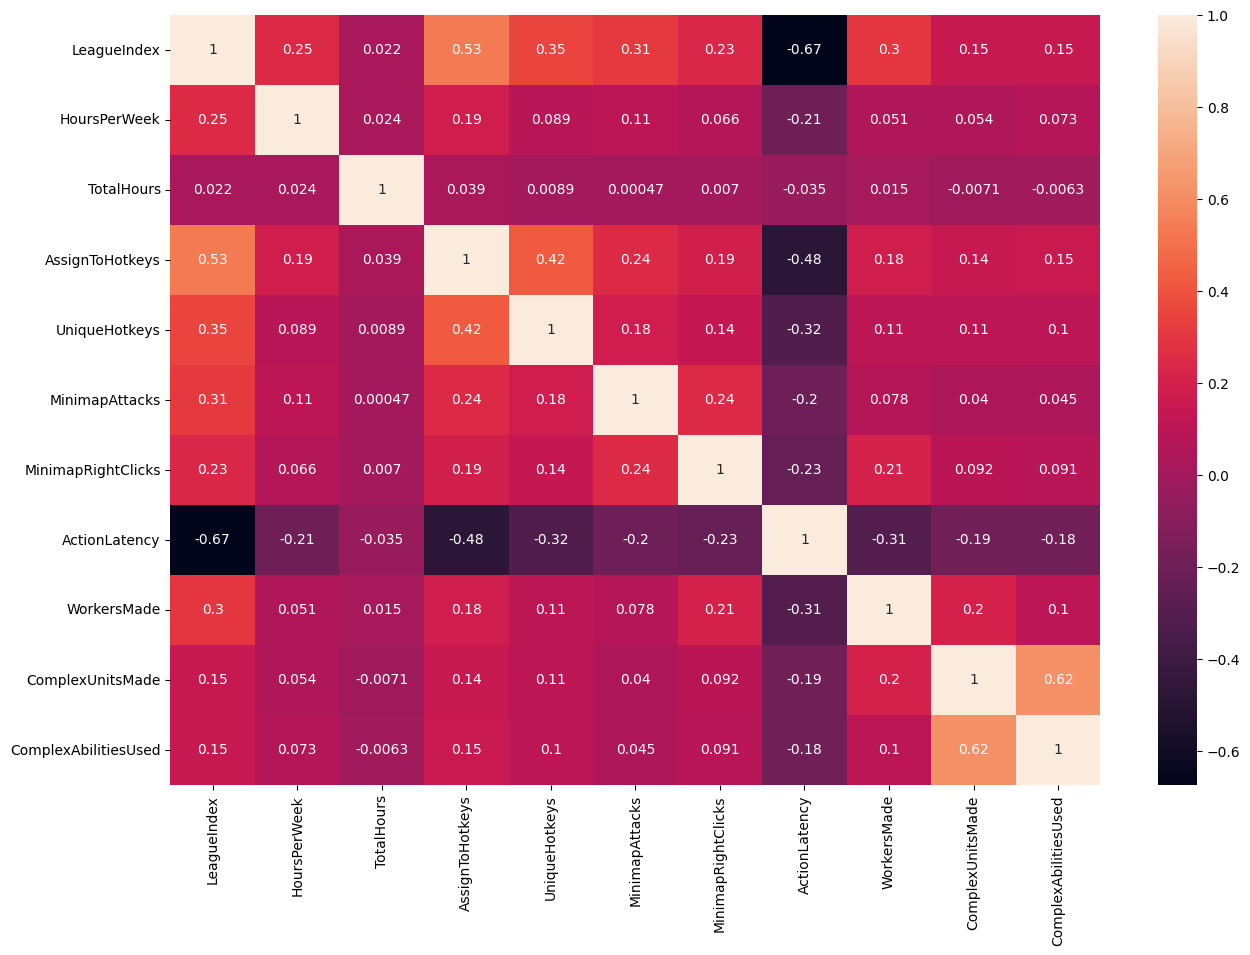

In [31]:
plt.figure(figsize=(15, 10))

corr = sc2df.corr()
sns.heatmap(corr, annot=True)

zatim ide primena visestruke regresije centrirana oko League Index-a (jer nam je cilj da utvrdimo sta i koliko utice na promenu plasmana)

In [32]:
#nezavisne promenljive
X = sc2df.drop(["LeagueIndex"], axis=1, inplace=False)

#zavisna promenljiva/target
y = sc2df["LeagueIndex"]

#intercept konstanta (note to self:value of target kad su independents 0) (povecanje preciznosti/citljivosti, daje baseline i pomera regression plane)
X = sm.add_constant(X)

#training data (note to self: regresija je model (you idiot), nije sirova formula. prvo treniras kao AI)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = sm.OLS(y_train, X_train).fit()
#note to self: size=0.3-->30% OG data, fiksiranje random_state omogucava reproduktibilnost jer uvek delis train/test na istom mestu
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            LeagueIndex   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     298.8
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:27:06   Log-Likelihood:                -3401.3
No. Observations:                2376   AIC:                             6825.
Df Residuals:                    2365   BIC:                             6888.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.1875 

In [33]:
#test prediction
y_pred = model.predict(X_test)

#model evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#data output
print("\nOLS Model Evaluation:")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")


OLS Model Evaluation:
Mean Squared Error: 26.50934155670991
Mean Absolute Error: 0.9748637825226858
R^2 Score: -10.751519796788902


sa ovime zakljucujemo da necemo primenjivati visestruku regresiju usred "overfitting"-a (trening i test podaci su isuvise slicni, stoga izabrana regresija ima previse preklapanja i ne moze se koristiti za analizu (vidljivo po tome sto su MSE i R^2 vredtonsti apsurdno velike))

sleceda ideja je primena Random Forest regresije (nelinearno drvo zakljucivanja, dobro funkcionise upravo u ovakvim slucajevima)

In [34]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("\nRandom Forest Regression Model Evaluation:")
print(f"Random Forest Regression - Mean Squared Error: {mse_rf}")
print(f"Random Forest Regression - Mean Absolute Error: {mae_rf}")
print(f"Random Forest Regression - R^2 Score: {r2_rf}")


Random Forest Regression Model Evaluation:
Random Forest Regression - Mean Squared Error: 0.9285565260058881
Random Forest Regression - Mean Absolute Error: 0.7693326790971541
Random Forest Regression - R^2 Score: 0.5883733900198005


mozemo videti da je preciznost kvadrata prosecne greske izuzetno mala, tj da je preciznost ~90%, dok je koeficijent determinacije (R^2 Score) na ~60% (koliko promena nezavisnih varijabli utice na zavisni target). Sledi graficki prikaz:

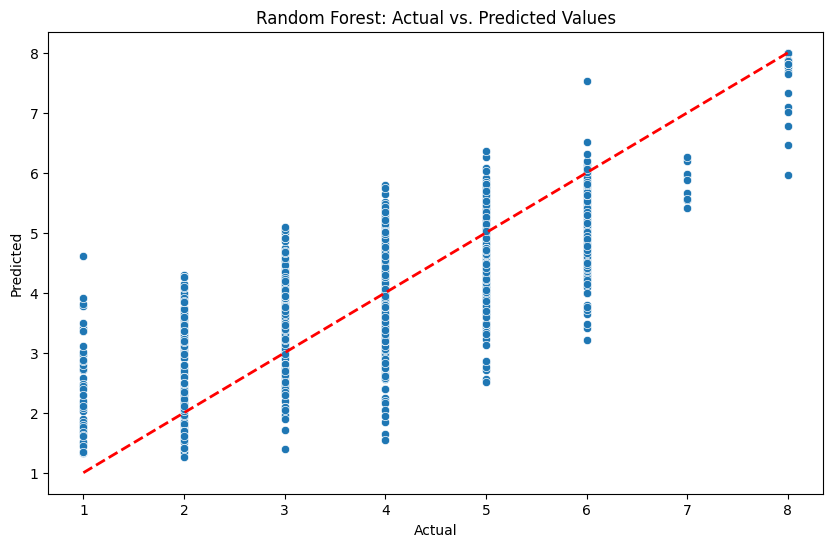

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs. Predicted Values')
plt.show()

ovde je ubacen GridSearch proces za automatizaciju tjuniranja parametara regresije, koji u nastavku nije iskoriscen iz prostog razloga sto mu treba isuvise vremena da bi bio prakticno primenljiv u petominutnoj odbrani ovog projekta. Ostavljen je kao dokaz rada, provereno funkcionise iako mu treba do 7-8 minuta koriscenjem T4 GPU runtime resursa. Cak sa trodelnim foldovanjem povecava preciznost za preko 1%, iako usled prevelikih delova dovodi do istovremenog uvecanja devijacije rezultata za isto toliko.

Testiranje broja foldova preko 5 nije testirano usled vremenskih ogranicenja, iako ukazuje na trend povecanja preciznosti kao i istovremenog smanjenja devijacije.

In [36]:
#param_grid = {
#    'n_estimators': [50, 100, 200],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'bootstrap': [True, False]
#}

In [37]:
#rf = RandomForestRegressor(random_state=42)
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
#grid_search.fit(X_train, y_train)
#print(f"Best parameters found: {grid_search.best_params_}")

In [38]:
#best_rf = grid_search.best_estimator_
#y_pred_best_rf = best_rf.predict(X_test)
#mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
#r2_best_rf = r2_score(y_test, y_pred_best_rf)
#
#print(f"Tuned Random Forest - Mean Squared Error: {mse_best_rf}")
#print(f"Tuned Random Forest - R^2 Score: {r2_best_rf}")

**dalje ide isptivanje estimacije parametara zdruzenih raspodela (kovarijansa/koeficijent relacije, linearna regresija)**

In [39]:
#matrica korelacije
corr_matrix = sc2df.corr()
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                      LeagueIndex  HoursPerWeek  TotalHours  AssignToHotkeys  \
LeagueIndex              1.000000      0.245744    0.022052         0.531125   
HoursPerWeek             0.245744      1.000000    0.023891         0.186574   
TotalHours               0.022052      0.023891    1.000000         0.038716   
AssignToHotkeys          0.531125      0.186574    0.038716         1.000000   
UniqueHotkeys            0.351213      0.088989    0.008864         0.420242   
MinimapAttacks           0.312544      0.106709    0.000466         0.242196   
MinimapRightClicks       0.233231      0.065650    0.006993         0.193043   
ActionLatency           -0.673939     -0.207837   -0.034706        -0.482191   
WorkersMade              0.295643      0.051350    0.014724         0.183065   
ComplexUnitsMade         0.148834      0.053716   -0.007055         0.144603   
ComplexAbilitiesUsed     0.145733      0.073102   -0.006264         0.154410   

                   

pozitivni rezultati >0.5 ukazuju na jaku pozitivnu vezu izmedju promenljivih
(-1-->savrseno negativno linearno
0-->bez linearne veze
1--?savrseno linearno pozitivno)

In [40]:
#matrica kovarijanse
cov_matrix = sc2df.cov()
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
                      LeagueIndex  HoursPerWeek    TotalHours  \
LeagueIndex              2.302281      4.460252  5.745699e+02   
HoursPerWeek             4.460252    143.084929  4.907351e+03   
TotalHours             574.569909   4907.351198  2.948817e+08   
AssignToHotkeys          0.000181      0.000502  1.495426e-01   
UniqueHotkeys            1.257835      2.512509  3.592702e+02   
MinimapAttacks           0.000079      0.000212  1.326196e-03   
MinimapRightClicks       0.000133      0.000296  4.527166e-02   
ActionLatency          -19.673387    -47.829997 -1.146581e+04   
WorkersMade              0.000233      0.000319  1.312278e-01   
ComplexUnitsMade         0.000025      0.000071 -1.345797e-02   
ComplexAbilitiesUsed     0.000059      0.000232 -2.853278e-02   

                      AssignToHotkeys  UniqueHotkeys  MinimapAttacks  \
LeagueIndex              1.812718e-04       1.257835    7.866137e-05   
HoursPerWeek             5.019992e-04       2.512509    

pozitivni rezultati ukazuju na povezanost smera promene promenljivih (ukoliko dodje do promene jedne, velike su sanse da ce se promeniti i druga, u istom smeru)

(note to self: razlika je da je korelacija striktno ogranicena -1-->1, dok kovarijansa nije standardizovana i zavisi od vrednosti promenljivih, stoga se koristi samo za utvrdjivanje smera linearne veze izmedju istih. Za precizniju procenu snage, koristiti korelaciju)

In [41]:
#koeficijent korelacije primenom linearne regresije
model = LinearRegression()
model.fit(X, y)
intercept = model.intercept_
coefficients = model.coef_
print(f"Intercept: {intercept}")
print("Coefficients:")
for feature, coef in zip(X.columns, coefficients):
  print(f"{feature}: {coef}")

Intercept: 5.321085333101357
Coefficients:
const: 0.0
HoursPerWeek: 0.010424410648528705
TotalHours: -5.842471053913584e-07
AssignToHotkeys: 1386.309210697966
UniqueHotkeys: 0.04308618417243886
MinimapAttacks: 1236.5429059179758
MinimapRightClicks: 73.35732693286266
ActionLatency: -0.037850106966201724
WorkersMade: 249.64106859966893
ComplexUnitsMade: -96.32847686461784
ComplexAbilitiesUsed: 3.2810519585806848


intercept pokazuje da je base League Index 5.283 kada su ostale promenljive 0. Pored toga, rezultati se tumace tako da npr za svaki dodatni sat nedeljno (HoursPerWeek) koji igrac provede igrajuci, League Index mu se povecava za 0.01 (pretpostavljajuci da su sve ostale promenljive konstantne)

***estimacija intervala poverenja***

In [42]:
sample_data = sc2df['LeagueIndex']
sample_mean = np.mean(sample_data)
sample_std = np.std(sample_data, ddof=1)
sample_size = len(sample_data)
confidence_level = 0.95
alpha = 1 - confidence_level
t_critical = stats.t.ppf(1 - alpha/2, df=sample_size - 1) #T-kriticna vrednost za conf.lvl. od 95%
margin_of_error = t_critical * (sample_std / np.sqrt(sample_size))
confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)
print(f"Sample Mean: {sample_mean}")
print(f"Confidence Interval: {confidence_interval}")

Sample Mean: 4.184094256259205
Confidence Interval: (np.float64(4.133036437967692), np.float64(4.235152074550718))


Ovo nam govori da mozemo biti 95% sigurni da League Index celokupne populacije stoji u intervalu 4.133-4.235

***predvidjanje uslovnih i bezuslovnih verovatnoca dogadjaja***

dogadjaj: predvidjanje plasmana igraca na osnovu odredjenih promenljivih. Za potrebe primera uzecemo Leagie Index >=5 kao "visok plasman" (nije da nije). Prvo racunamo bezuslovnu:

In [43]:
#bezuslovna verovatnoca se racuna bez uticaja drugih promenljivih:
total_players = len(sc2df)
high_league_players = len(sc2df[sc2df['LeagueIndex'] >= 5])
P_high_league = high_league_players / total_players
print(f"Unconditional Probability of being in High League: {P_high_league:.2f}")

Unconditional Probability of being in High League: 0.45


rezultat nam govori da postoji 45% sanse da je nasumicno izabran igrac iz dataset-a visoko plasiran (uzimajuci u obzir prethodnu definiciju istog)

za uslovnu verovatnocu cemo uzeti primer predvidjanja plasmana igraca ako igraju vise od 20h nedeljno

In [44]:
#igraci sa >20h nedeljno
high_hours_players = sc2df[sc2df['HoursPerWeek'] > 20]
total_high_hours_players = len(high_hours_players)

#visoko plasirani igraci medju onima koji igraju >20h nedeljno
high_league_high_hours_players = len(high_hours_players[high_hours_players['LeagueIndex'] >= 5])
P_high_league_given_high_hours = high_league_high_hours_players / total_high_hours_players
print(f"Conditional Probability of being in High League given studying more than 20 hours per week: {P_high_league_given_high_hours:.2f}")

Conditional Probability of being in High League given studying more than 20 hours per week: 0.63


ovaj rezultat nam govori da procenat sanse da je nasumicno odabrani igrac visoko plasiran raste do 63%, sto dalje govori da se povecanjem sati igranja nedeljno znatno povecava sansa visokog plasmana (surprising nobody)

***estimacija parametara raspodela pojedinacnih promenljivih (koristeci standardnu devijaciju)***

Ovde cemo izracunati devijaciju kasnjenja komandi igraca (ActionLatency) u odnosu na srednju vrednost (mean)

In [45]:
action_latency = sc2df['ActionLatency']
#srednja vrednost
mean_action_latency = action_latency.mean()
print(f"Mean of ActionLatency: {mean_action_latency:.2f}")
#standardna devijacija
std_action_latency = action_latency.std()
print(f"Standard Deviation of ActionLatency: {std_action_latency:.2f}")

Mean of ActionLatency: 63.74
Standard Deviation of ActionLatency: 19.24


rezultati pokazuju da je srednja vrednost 63.74ms, a standardna devijacija 19.24ms. Videti graficki prikaz ispod:

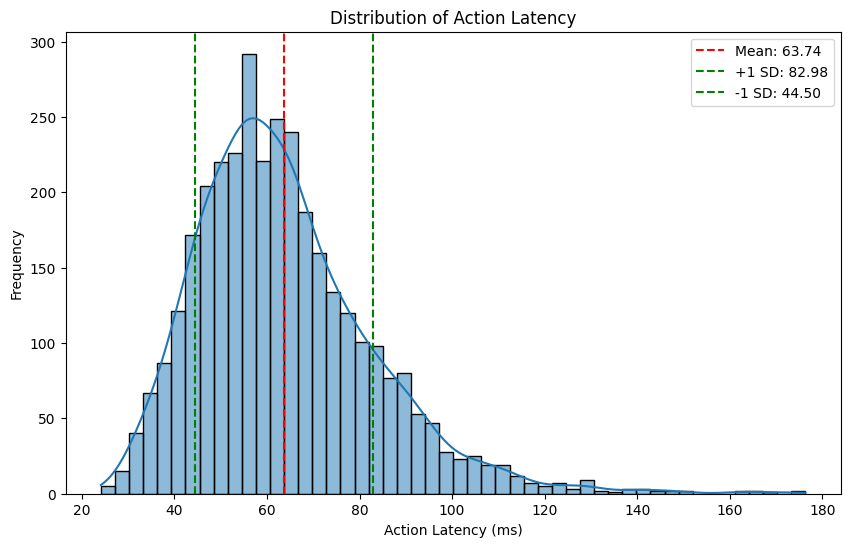

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(action_latency, kde=True)
plt.axvline(mean_action_latency, color='r', linestyle='--', label=f'Mean: {mean_action_latency:.2f}')
plt.axvline(mean_action_latency + std_action_latency, color='g', linestyle='--', label=f'+1 SD: {mean_action_latency + std_action_latency:.2f}')
plt.axvline(mean_action_latency - std_action_latency, color='g', linestyle='--', label=f'-1 SD: {mean_action_latency - std_action_latency:.2f}')
plt.xlabel('Action Latency (ms)')
plt.ylabel('Frequency')
plt.title('Distribution of Action Latency')
plt.legend()
plt.show()

*(treba imati na umu da igraci koriste "empty keystrokes" tj prazne komande da bi zadrzali razgibanost saka u toku meceva, kao i visok APM (actions per minute), sto utice na validnost rezultata. Uticaj je subjektivne vrste i ne moze se uracunati u sam dataset, stoga ovi podaci kao i njihovi rezultati nisu primenljivi za merenja stvarnih brzina reakcije, koje kod prosecne netrenirane odrasle osobe (u odnosu na vizuelni stimulus) stupaju u interval od ~250ms)*

# **POCETAK ZADATKA AI**

In [47]:
sc2df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LeagueIndex           3395 non-null   int64  
 1   HoursPerWeek          3395 non-null   float64
 2   TotalHours            3395 non-null   float64
 3   AssignToHotkeys       3395 non-null   float64
 4   UniqueHotkeys         3395 non-null   int64  
 5   MinimapAttacks        3395 non-null   float64
 6   MinimapRightClicks    3395 non-null   float64
 7   ActionLatency         3395 non-null   float64
 8   WorkersMade           3395 non-null   float64
 9   ComplexUnitsMade      3395 non-null   float64
 10  ComplexAbilitiesUsed  3395 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 291.9 KB


In [48]:
sc2df.describe()

,LeagueIndex,HoursPerWeek,TotalHours,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,ActionLatency,WorkersMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4.184094,16.105449,956.553166,0.000374,4.364654,0.000098,0.000387,63.739403,0.001032,0.000059,0.000142
std,1.517327,11.961811,17172.120355,0.000225,2.360333,0.000166,0.000377,19.238869,0.000519,0.000111,0.000265
min,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,24.093600,0.000077,0.000000,0.000000
25%,3.000000,8.000000,300.000000,0.000204,3.000000,0.000000,0.000140,50.446600,0.000683,0.000000,0.000000
50%,4.000000,12.000000,500.000000,0.000353,4.000000,0.000040,0.000281,60.931800,0.000905,0.000000,0.000020
75%,5.000000,20.000000,800.000000,0.000499,6.000000,0.000119,0.000514,73.681300,0.001259,0.000086,0.000181
max,8.000000,168.000000,1000000.000000,0.001752,10.000000,0.003019,0.004041,176.372100,0.005149,0.000902,0.003084


In [49]:
print("\nOutlier Analysis using a 3×IQR rule:\n")

# Check each numeric feature for outliers
for col in sc2df.select_dtypes(include=['number']).columns:
    Q1 = sc2df[col].quantile(0.25)
    Q3 = sc2df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = sc2df[(sc2df[col] < lower_bound) | (sc2df[col] > upper_bound)]
    outlier_count = outliers.shape[0]

    print(f"Column: {col}")
    print(f"  Q1: {Q1:.3f}, Median: {sc2df[col].median():.3f}, Q3: {Q3:.3f}")
    print(f"  IQR: {IQR:.3f}")
    print(f"  Lower Bound: {lower_bound:.3f}, Upper Bound: {upper_bound:.3f}")
    print(f"  Number of Outliers: {outlier_count}\n")


Outlier Analysis using a 3×IQR rule:

Column: LeagueIndex
  Q1: 3.000, Median: 4.000, Q3: 5.000
  IQR: 2.000
  Lower Bound: -3.000, Upper Bound: 11.000
  Number of Outliers: 0

Column: HoursPerWeek
  Q1: 8.000, Median: 12.000, Q3: 20.000
  IQR: 12.000
  Lower Bound: -28.000, Upper Bound: 56.000
  Number of Outliers: 22

Column: TotalHours
  Q1: 300.000, Median: 500.000, Q3: 800.000
  IQR: 500.000
  Lower Bound: -1200.000, Upper Bound: 2300.000
  Number of Outliers: 57

Column: AssignToHotkeys
  Q1: 0.000, Median: 0.000, Q3: 0.000
  IQR: 0.000
  Lower Bound: -0.001, Upper Bound: 0.001
  Number of Outliers: 9

Column: UniqueHotkeys
  Q1: 3.000, Median: 4.000, Q3: 6.000
  IQR: 3.000
  Lower Bound: -6.000, Upper Bound: 15.000
  Number of Outliers: 0

Column: MinimapAttacks
  Q1: 0.000, Median: 0.000, Q3: 0.000
  IQR: 0.000
  Lower Bound: -0.000, Upper Bound: 0.000
  Number of Outliers: 105

Column: MinimapRightClicks
  Q1: 0.000, Median: 0.000, Q3: 0.001
  IQR: 0.000
  Lower Bound: -0.001

S obzirom na to da je tokom koriscenja RF regresora preciznost kvadrata prosecne greske izuzetno mala, tj da je preciznost ~90%, dok je koeficijent determinacije (R^2 Score) na ~60% (koliko promena nezavisnih varijabli utice na zavisni target), a GridSearchCV beskorisno dugotrajan u poredjenju sa dobitcima, za tjuniranje hiperparametara ce se pokusati koristiti LIPO algoritam sa fleksibilnim prostorom pretrage (za dodatno automatizovanje poboljsanja bez potrebe za tjuniranjem tjunera kao kod npr Bajezove optimizacije (I'm *lazy* lazy))

*(LIPO dostupan na [https://github.com/jdb78/lipo](https://github.com/jdb78/lipo))*

In [50]:
#fiksiranje globalne Fold funkcije za unakrsnu validaciju zbog uniformnosti koda
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)

In [51]:
# Define the hyperparameter space:
# Each key maps to a list [lower_bound, upper_bound] (for numeric variables).
# (Categorical variables can be passed as a list of choices.)
param_space = {
    'n_estimators': [50, 200],      # integer parameter: number of trees
    'max_depth': [1, 50],          # integer parameter: maximum depth of trees
    'min_samples_split': [2, 20],   # integer parameter: minimum samples to split an internal node
    'min_samples_leaf': [1, 10]     # integer parameter: minimum samples at a leaf node
}

# Create an instance of LIPOSearchCV.
# Here:
# - n_iter specifies the number of evaluations.
# - flexible_bound_threshold=0.1 tells the optimizer to enlarge bounds if the optimum is within the lower 10% or upper 10%.
# - scoring is set to 'neg_mean_squared_error' (as used by scikit-learn) to be maximized (more positive is better).
# - 5-fold cross-validation is used.
lipo_search = LIPOSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_space=param_space,
    n_iter=150,
    flexible_bound_threshold=0.2,
    flexible_bounds={
        'n_estimators': [True, True],
        'max_depth': [False, True], #prevents lowering bounds below the minimum required for RandomForest
        'min_samples_split': [False, True], #see above
        'min_samples_leaf': [False, True] #see above above
    },
    scoring='neg_mean_squared_error',
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Run the hyperparameter search on the training data
lipo_search.fit(X_train, y_train)

# After tuning, view the best hyperparameters:
print("****** LIPO Hyperparameter Tuning Results ******")
print("Best hyperparameters found:")
print(lipo_search.best_params_)

# --- Training and Evaluating the Tuned RandomForestRegressor ---
# Extract the best estimator from LIPOSearchCV (the estimator is refit on the full training set by default)
tuned_rf = lipo_search.best_estimator_
y_pred_tuned = tuned_rf.predict(X_test)

mse_tuned = mean_squared_error(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n****** Tuned RandomForestRegressor Evaluation ******")
print(f"Mean Squared Error: {mse_tuned}")
print(f"Mean Absolute Error: {mae_tuned}")
print(f"R^2 Score: {r2_tuned}")

Best params at iteration --- with score ----:   0%|          | 0/150 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

**LIPO-Tuned RandomForest Result Analysis**

model pokazuje skormna ali postojana poboljsanja u odnosu na baseline. Detaljnija analiza sledi ispod:

**Error Reduction:**

- **MSE:** smanjen sa 0.9033 na 0.8907  
- **MAE:** smanjen sa 0.7539 na 0.7524  
- **R²:** povecan sa 0.5996 na 0.6052  

Iako su ove razlike male, ukazuju na to da je LIPO uspesno iskoristio prostor hiperparametara da izvuce dodatne performanse. Ova vrsta postepenog poboljsanja je pogotovo vazna za real-world scenarije.

**Hyperparameter Changes:**

- **n_estimators:** Tjunirana vrednost 587 (u poredjenju sa default od 100) znaci da se skup sastoji od mnogo vise pojedinacnih drveta sto uglavnom pomaze smanjenju varijanse.
- **max_depth:** Dozvoljavanje dubine od 99 dopusta pojedinacnim stablima da rastu izuzetno duboko i zauzmu kompleksne interakcije; iako duboka stabla nose sa sobom risk od overfitting-a, to je kontrolisano ostalim hiperparametrima.
- **min_samples_split:** Povecavanje do 24 forsira konzervantivnije splitove, time smanjujuci overfitting putem zahtevanja veceg broja uzoraka za node split.
- **min_samples_leaf:** Zadrzavanje ovoga na 1 dozvoljava fleksibilnost u strukturi stabla, sto moze biti kriticno imajuci na umu veliku dozvoljenu dubinu.

**Interpretation:**

Uocena poboljsanja metrika sugerisu da tjunirani model efektivnije obuhvata osnovne (underlying, nmp kako da prevedem) odnose medju podacima iako su promene suptilne. U primeni nad malim datasetovima poput ovog takva inkrementalna poboljsanja su izuzetno vazna, jer prikazuju poboljsanju generalizaciju.

**Practical Considerations:**

- Iako boost u performansama nije prevelik, ukazuje na kretanje u pravom smeru.
- Kada baseline model radi poprilicno dobro, tjuniranje hiperparametara uglavnom doprinosi malim ali vrednim i osetnim poboljsanjima.
- Dodatni troskovi izracunavanja i istrazivanja sireg hiperparametarskog prostora moze biti opravdana kada je cilj izvuci svaki komad prediktivne preciznosti bez opseznog rucnog tjuniranja.

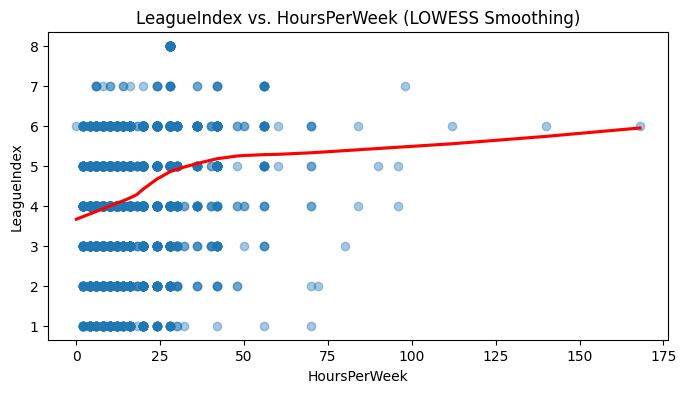

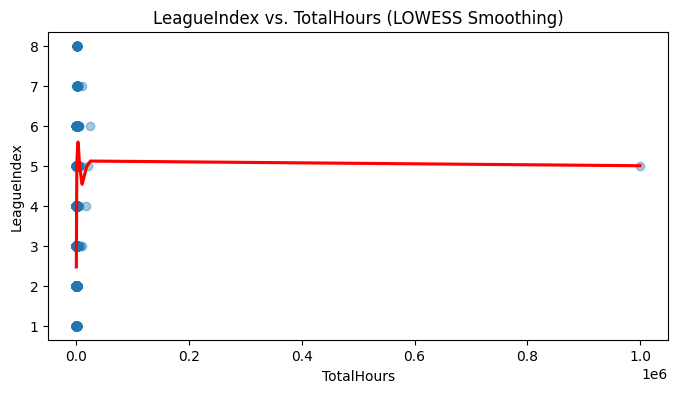

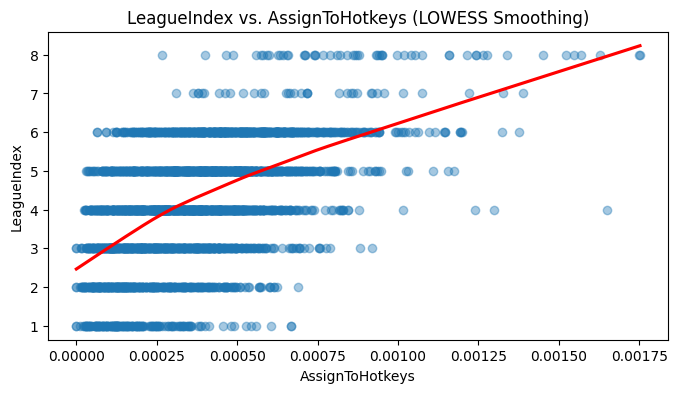

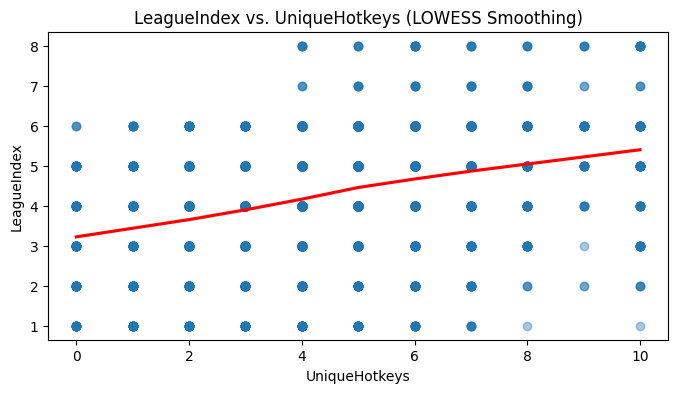

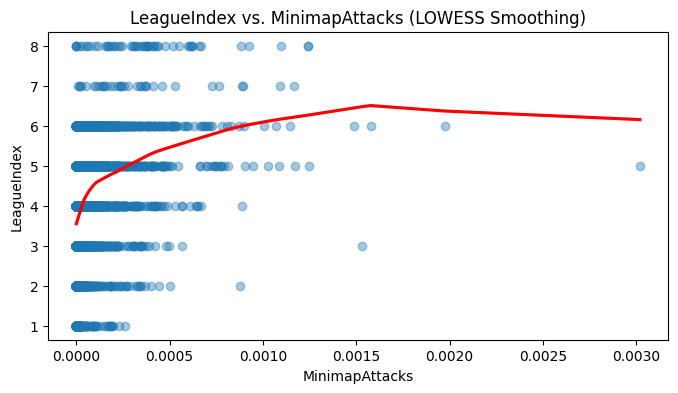

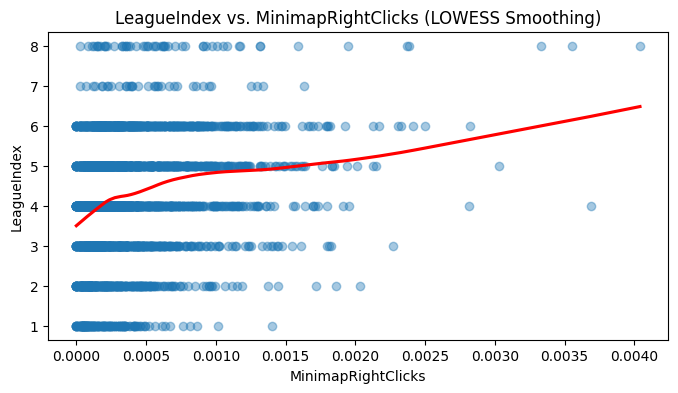

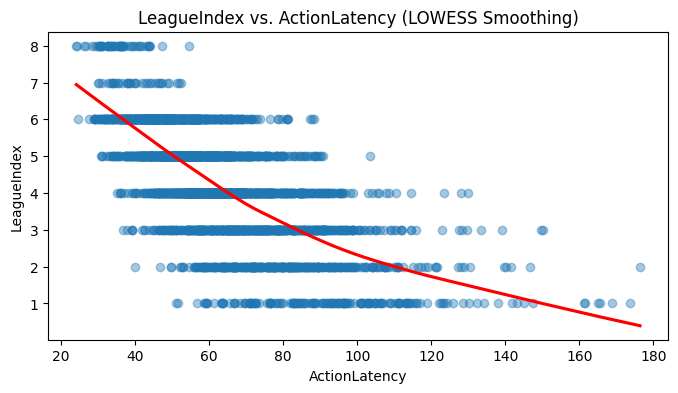

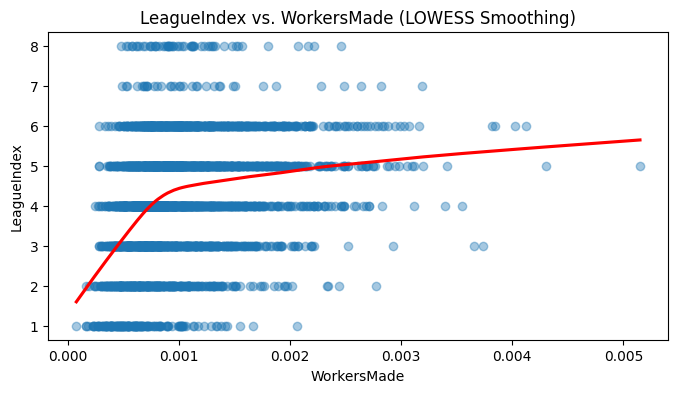

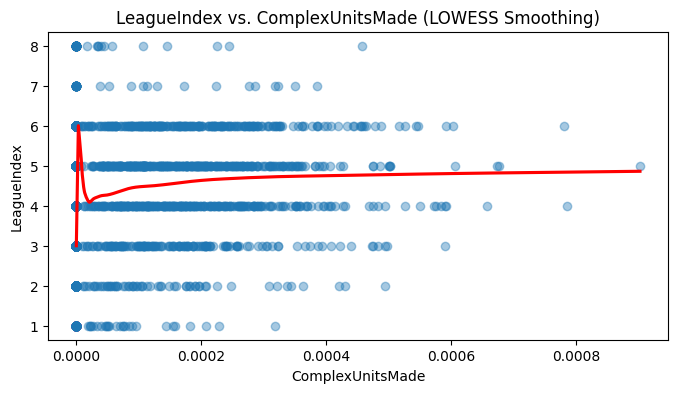

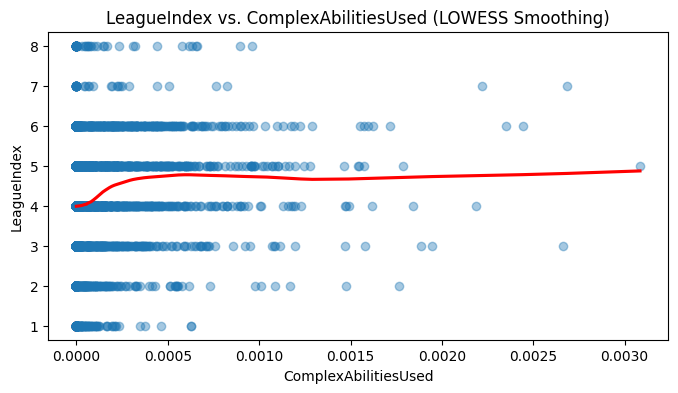

In [52]:
# List of predictor columns (all columns except 'LeagueIndex')
predictors = sc2df.columns.drop("LeagueIndex")

# Create a scatter plot with LOWESS smoothing for each predictor vs. LeagueIndex
for col in predictors:
    plt.figure(figsize=(8, 4))
    sns.regplot(x=sc2df[col], y=sc2df['LeagueIndex'],
                lowess=True,  # use LOWESS smoothing
                scatter_kws={'alpha': 0.4},
                line_kws={'color': 'red'})
    plt.title(f"LeagueIndex vs. {col} (LOWESS Smoothing)")
    plt.xlabel(col)
    plt.ylabel("LeagueIndex")
    plt.show()

In [53]:
# Define the objective function for Optuna using the pre-split training data.
def objective(trial: Trial) -> float:
    # Suggest values for hyperparameters: C and gamma on log scale, epsilon linearly.
    C = trial.suggest_loguniform("C", 0.001, 1000)
    epsilon = trial.suggest_uniform("epsilon", 0.001, 1.0)
    gamma = trial.suggest_loguniform("gamma", 0.0001, 1.0)

    # Build a pipeline with RobustScaler and SVR.
    model = make_pipeline(RobustScaler(), SVR(C=C, epsilon=epsilon, gamma=float(gamma)))  # type: ignore

    # Negative mean squared error is used, so we take its negative average.
    scores = cross_val_score(model, X_train, y_train, cv=cv_splitter, scoring="neg_mean_squared_error", n_jobs=-1)
    avg_mse = -np.mean(scores)
    #explicit conversion to Python float to satisfy typechecker
    return float(avg_mse)

# Create the Optuna study using the TPE sampler.
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=150)

print("Best hyperparameters:", study.best_params)
print("Best training MSE:", study.best_value)

# Build the final model with the best hyperparameters from the tuning.
best_svr = make_pipeline(RobustScaler(), SVR(**study.best_params))
best_svr.fit(X_train, y_train)
y_pred_svr = best_svr.predict(X_test)

# Evaluate final SVR model performance on the test set.
mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr  = r2_score(y_test, y_pred_svr)

print("Test SVR - Mean Squared Error:", mse_svr)
print("Test SVR - Mean Absolute Error:", mae_svr)
print("Test SVR - R^2 Score:", r2_svr)

[I 2025-04-25 11:01:40,813] A new study created in memory with name: no-name-c4ef5c62-4560-480d-8b3a-80cf023e0772
[I 2025-04-25 11:01:42,231] Trial 0 finished with value: 0.9501450950305295 and parameters: {'C': 26.15615063365636, 'epsilon': 0.011812760178440733, 'gamma': 0.0009533348281338143}. Best is trial 0 with value: 0.9501450950305295.
[I 2025-04-25 11:01:43,654] Trial 1 finished with value: 0.9522341124260782 and parameters: {'C': 16.038850712351497, 'epsilon': 0.31935941590482203, 'gamma': 0.0011066927042659995}. Best is trial 0 with value: 0.9501450950305295.
[I 2025-04-25 11:01:45,133] Trial 2 finished with value: 2.1417869284266637 and parameters: {'C': 0.0017501500748800518, 'epsilon': 0.7803673807507301, 'gamma': 0.024055449592962887}. Best is trial 0 with value: 0.9501450950305295.
[I 2025-04-25 11:01:58,499] Trial 3 finished with value: 1.0273428496882147 and parameters: {'C': 716.2118744285168, 'epsilon': 0.5412953078917853, 'gamma': 0.013722610407063802}. Best is tria

Best hyperparameters: {'C': 22.721381916647005, 'epsilon': 0.37213831797217706, 'gamma': 0.011250248495835275}
Best training MSE: 0.8873598578946778
Test SVR - Mean Squared Error: 0.9290966705558007
Test SVR - Mean Absolute Error: 0.7712069628652962
Test SVR - R^2 Score: 0.5881339453939185


**TPE‑SVR Result Analysis**

Tjunirani SVR model (koristeci TPE) je kompetitivan ali nedostaje tik ispod RF varijanti. Detaljnija analiza sledi ispod:

**Error Metrics:**

- **MSE:** TPE‑SVR model dostize MSE od ~0.9241, sto je malo vise od baseline RF (~0.9033) i LIPO‑RF (~0.8907).
- **MAE:** Njegov MAE sa ~0.7703 je takodje tik iznad i baseline RF (~0.7539) i LIPO‑RF (~0.7524).
- **R²:** R² vrednost od ~0.5903 ukazuje na malo manju sposobnost da objasni variajse u poredjenju sa baseline RF (~0.5996) i LIPO‑RF (~0.6052).

**Interpretation:**

Ove razlike—iako skromne—impliciraju na to da je SVR tjuniran putem TPE ipak korak iza RF-a sto se tice robustnosti prilikom primene na ovom datasetu. Osetljivost SVR-a na njegove hiperparametre (C, ε, i γ) znaci da proporcionalno male devijacije mogu doprineti osetno losijim ishodima. Drugim recima, iako je TPE-SVR tandem izuzetno kompetetivan, skupovna priroda LIPO-RF tandema mu daje blagu prednost u rukovanjem kompleksnim i/ili bucnim podacima (bukv.prev.: noisy data).

**Practical Implications:**

- **Model Sensitivity:**  
  SVR-ove performanse su izyzetno osetljive na hiperparametre. Cak i najmanje greske u prilagodjavanju mogu (i to cesto) imati vrlo primetne efekte, koji se ogledavaju u marginalnom raskoraku u performance metrikama (u poredjenju sa baseline i LIPO-RF tandemom).
  
- **Robustness of RF:**  
  RandomForest modeli, cak i sa podrazumevanim osnovnim postavkama, imaju tendenciju da budu robustniji na malim datasetovima i manje osetljivi na fluktuacije hiperparametara—stoga ostvarujuci blago bolje performanse.
  
- **Ensemble Consideration:**  
  Uprkos marginalnim razlikama, ukljucivanje TPE-SVR tandema uporedo sa LIPO-RF moze biti korisno. Komplementarne snage oba modela (usled njihovih razlicitih pristupa) mogu dalje poboljsati geoeralne prediktivne performanse.

**Conclusion:**

Sa MSE od ~0.9241,MAE od ~0.7703,i R² of ~0.5903,TPE‑SVR tandem je solidan. Medjutim, za ovaj specificni dataset obe RF varijante pokazuju blage prednosti. Ipak, jedinstvene snage SVR-a mu omogucavaju da ozadrzi poziciju kandidata, pogotovo ako ce se kombinovati sa drugim modelima u ansambl konfiguracijama.

In [54]:
# Composite objective function that combines MSE and MAE
def composite_objective_xgb(params):
    """
    Objective function for Differential Evolution using a composite of MSE and MAE.
    The 'params' vector contains the hyperparameters in the order:
    [n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda]
    """
    # Unpack parameters
    n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda = params

    # Convert parameters that are supposed to be integers
    n_estimators = int(round(n_estimators))
    max_depth = int(round(max_depth))

    # Create the XGBoost regressor with these hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    # Evaluate using cross-validation
    mse_scores = cross_val_score(
        model, X_train, y_train, cv=cv_splitter,
        scoring="neg_mean_squared_error", n_jobs=-1
    )
    mae_scores = cross_val_score(
        model, X_train, y_train, cv=cv_splitter,
        scoring="neg_mean_absolute_error", n_jobs=-1
    )

    # Calculate the negative scores, then take their means
    mse = -np.mean(mse_scores)
    mae = -np.mean(mae_scores)

    # Define the alpha weight
    alpha_weight = 0.4

    # Composite objective: lower is better
    composite_score = mse + alpha_weight * mae
    return composite_score

# Define the hyperparameter bounds for Differential Evolution
bounds = [
    (50, 1000),         # n_estimators
    (3, 20),            # max_depth
    (0.01, 0.3),        # learning_rate
    (0.5, 1.0),         # subsample
    (0.5, 1.0),         # colsample_bytree
    (0, 10),            # gamma
    (0, 10),            # reg_alpha (L1 regularization)
    (0, 10)             # reg_lambda (L2 regularization)
]

# Run Differential Evolution with additional settings and verbose output
result = differential_evolution(
    composite_objective_xgb,
    bounds,
    maxiter=150,
    seed=42,
    disp=True,           # Verbose output to monitor progress
    popsize=15,
    mutation=(0.5, 1)
)

print("****** DE Hyperparameter Tuning Results for XGBoost ******")
print("Raw best hyperparameters vector:")
print(result.x)

# Process the raw parameter vector into a dictionary
best_params = result.x
best_params_dict = {
    'n_estimators': int(round(best_params[0])),
    'max_depth': int(round(best_params[1])),
    'learning_rate': best_params[2],
    'subsample': best_params[3],
    'colsample_bytree': best_params[4],
    'gamma': best_params[5],
    'reg_alpha': best_params[6],
    'reg_lambda': best_params[7]
}
print("\nBest hyperparameters (interpreted):")
print(best_params_dict)
print("\nBest composite training score:", result.fun)

# Build and evaluate the final XGBoost model
best_xgb = XGBRegressor(
    **best_params_dict,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
mae_xgb = mean_absolute_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)

print("\n****** Tuned XGBoost Evaluation ******")
print("Mean Squared Error:", mse_xgb)
print("Mean Absolute Error:", mae_xgb)
print("R^2 Score:", r2_xgb)

differential_evolution step 1: f(x)= 1.1591852736473083
differential_evolution step 2: f(x)= 1.1590946507453919
differential_evolution step 3: f(x)= 1.1550042724609375
Polishing solution with 'L-BFGS-B'
****** DE Hyperparameter Tuning Results for XGBoost ******
Raw best hyperparameters vector:
[7.74084725e+02 6.31580866e+00 2.04134523e-02 5.21937005e-01
 9.93381719e-01 3.58198378e+00 7.37046314e-01 3.18069633e+00]

Best hyperparameters (interpreted):
{'n_estimators': 774, 'max_depth': 6, 'learning_rate': np.float64(0.020413452270199143), 'subsample': np.float64(0.5219370046670909), 'colsample_bytree': np.float64(0.9933817190524692), 'gamma': np.float64(3.5819837809438266), 'reg_alpha': np.float64(0.737046314436039), 'reg_lambda': np.float64(3.180696328787419)}

Best composite training score: 1.1541718649864197

****** Tuned XGBoost Evaluation ******
Mean Squared Error: 0.8688201308250427
Mean Absolute Error: 0.7541354894638062
R^2 Score: 0.6148543953895569


**XGBoost Hyperparameter Tuning and Evaluation Results using Differencial Evolution**  
*(aka why we're using 0.4 as the alpha weight value in the composite loss function)*

| Experiment Label    | DE Step 1 f(x) | DE Step 2 f(x) | DE Step 3 f(x) | Best Composite Score | Tuned MSE | Tuned MAE | Tuned R²  |
|---------------------|----------------|----------------|----------------|----------------------|-----------|-----------|-----------|
| Baseline (MSE only) | –              | –              | –              | 0.85179              | 0.88101   | 0.76173   | 0.60945   |
| 0.1                 | 0.93778        | 0.93778        | 0.93096        | 0.92892              | 0.88401   | 0.76209   | 0.60812   |
| 0.3                 | 1.08517        | 1.08505        | 1.08199        | 1.08189              | 0.88448   | 0.76048   | 0.60791   |
| 0.4                 | 1.15919        | 1.15909        | 1.15500        | 1.15417              | 0.86882   | 0.75414   | 0.61485   |
| 0.5                 | 1.23377        | 1.22635        | –              | 1.22208              | 0.87606   | 0.75876   | 0.61165   |
| 0.8                 | 1.45576        | 1.45450        | –              | 1.45230              | 0.88381   | 0.76186   | 0.60821   |
| 1.0                 | 1.60375        | 1.60251        | –              | 1.60088              | 0.88265   | 0.76093   | 0.60872   |
| 1.2                 | 1.75174        | 1.74032        | –              | 1.73902              | 0.88311   | 0.76023   | 0.60852   |

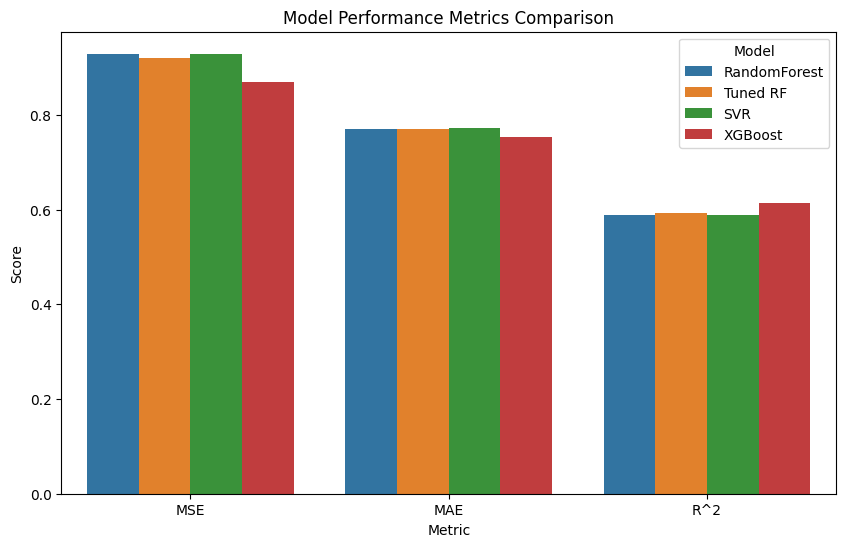

In [55]:
# Prepare a dataframe with model names and metrics.
data = {
    'Model': ['RandomForest', 'Tuned RF', 'SVR', 'XGBoost'],
    'MSE': [mse_rf, mse_tuned, mse_svr, mse_xgb],
    'MAE': [mae_rf, mae_tuned, mae_svr, mae_xgb],
    'R^2': [r2_rf, r2_tuned, r2_svr, r2_xgb]
}

df_metrics = pd.DataFrame(data)

# Melt the DataFrame for use with Seaborn (this converts from wide to long format).
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create a grouped bar plot.
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)

plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')

plt.show()

# **GODZILLA**

In [56]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  []


In [ ]:
tf.config.set_visible_devices([], 'GPU')

# Initialize Ray (only once!)
ray.init(ignore_reinit_error=True)

# ==============================================================================
# DATA PREPARATION: Convert Training Data to a Ray Dataset (Option B)
# ==============================================================================

# Scale features with RobustScaler, which reduces the impact of extreme outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================================================================
# DEFINE COMPOSITE LOSS FUNCTION
# ==============================================================================

def composite_loss(alpha=0.4):
    def loss_fn(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        mae = tf.reduce_mean(tf.abs(y_true - y_pred))
        return mse + alpha * mae
    return loss_fn

# ==============================================================================
# ASHA (Asynchronous Successive Halving) SCHEDULER
# ==============================================================================

scheduler = ASHAScheduler(
    max_t=50,         # Maximum time (e.g., epochs) a trial can run.
    grace_period=5,   # Minimum epochs each trial will run before being considered for stopping.
    reduction_factor=2 #approx. half of less promising trials will be pruned each decision point
)

# ==============================================================================
# TRAINING FUNCTION WITH RAY TUNE & RAY TRAIN
# ==============================================================================

def train_model(config):
    """
    Builds and trains an MLP with hyperparameters from config.

    - Hidden Layers: 1 to 5 layers; number of neurons per layer is chosen from 16 to 256 (step 16).
    - Dropout: For each layer, if the corresponding dropout flag is True, a dropout layer (fixed rate 0.2) is added.
      (Dynamic dropout rates are possible but are not used here.)
    - Optimizer: Chooses between Nadam and RMSprop (with momentum), with hyperparameters tuned.
    - Loss: Composite loss combining MSE and MAE (with alpha=0.4).

    Early Stopping: Patience is set to 5 epochs (if no improvement on validation loss is seen for 5 epochs,
    training stops early).
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

    num_layers = config["num_layers"]
    for i in range(num_layers):
        units = config[f"units_{i}"]
        model.add(layers.Dense(units, activation="relu"))
        if config.get(f"dropout_{i}", False):
            model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation="linear"))

    # Choose optimizer based on config.
    if config["optimizer"] == "Nadam":
        optimizer = keras.optimizers.Nadam(
            learning_rate=config["learning_rate"],
            beta_1=config["beta_1"],
            beta_2=config["beta_2"]
        )
    elif config["optimizer"] == "RMSprop":
        optimizer = keras.optimizers.RMSprop(
            learning_rate=config["learning_rate"],
            rho=config["rho"],
            momentum=config["momentum"]
        )
    else:
      raise ValueError(f"Unsupported optimizer: {config['optimizer']}")

    model.compile(optimizer=optimizer,
                  loss=composite_loss(alpha=0.4),
                  metrics=["mae", "mse"])

    callbacks = [
        # Report metrics to Ray Tune each epoch.
        TuneReportCallback({"val_loss": "val_loss", "val_mae": "val_mae"}, on="epoch_end"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

    # Use global data; here we split a part for validation.
    model.fit(X_train_scaled, y_train,
              validation_split=0.2,
              epochs=config["epochs"],
              batch_size=config["batch_size"],
              verbose=0,
              callbacks=callbacks)

# ==============================================================================
# DEFINE HYPERPARAMETER SEARCH SPACE
# ==============================================================================

search_space = {
    "optimizer": tune.choice(["Nadam", "RMSprop"]),
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    # Nadam-specific
    "beta_1": tune.uniform(0.8, 0.99),
    "beta_2": tune.uniform(0.9, 0.999),
    # RMSprop-specific
    "rho": tune.uniform(0.8, 0.99),
    "momentum": tune.uniform(0.0, 0.9),
    # Network architecture:
    "num_layers": tune.choice([1, 2, 3, 4, 5]),
    "units_0": tune.choice(list(range(16, 129, 16))),
    "units_1": tune.choice(list(range(16, 129, 16))),
    "units_2": tune.choice(list(range(16, 129, 16))),
    "units_3": tune.choice(list(range(16, 129, 16))),
    "units_4": tune.choice(list(range(16, 129, 16))),
    "dropout_0": tune.choice([True, False]),
    "dropout_1": tune.choice([True, False]),
    "dropout_2": tune.choice([True, False]),
    "dropout_3": tune.choice([True, False]),
    "dropout_4": tune.choice([True, False]),
    # Training hyperparameters:
    "epochs": 50,
    "batch_size": tune.choice([16, 32, 64])
}

# ==============================================================================
# WRAP TRAINING WITH RAY TRAIN & RUN RAY TUNE (OPTION A)
# ==============================================================================

def train_with_ray_train(config):
    """
    Wrapper to run our training function via Ray Train.
    For Option A, we do not pass a dataset because our training function uses global data.
    """
    scaling_config = ScalingConfig(num_workers=1, use_gpu=False)
    trainer = TensorflowTrainer(
        train_loop_per_worker=train_model,
        scaling_config=scaling_config
        # No datasets parameter is provided.
    )
    trainer.fit()

analysis = tune.run(
    tune.with_parameters(train_with_ray_train),
    resources_per_trial={"cpu": 2, "gpu": 0},  # Adjust resource allocation per trial
    config=search_space,
    metric="val_loss",
    mode="min",
    num_samples=20,  # Explore 20 hyperparameter configurations
    raise_on_failed_trial=False,  # Do not abort if some trials fail
    storage_path="file:///content/ray_tune_results",  # Proper URI for storage path
    verbose=1,  # Reduced verbosity for readability
    scheduler=scheduler  # Here is where ASHA is integrated
)
for trial in analysis.trials:
    print(trial.status)

print("Best hyperparameters found were:", analysis.best_config)

# ==============================================================================
# RETRAIN THE FINAL MODEL WITH THE BEST HYPERPARAMETERS & EVALUATE
# ==============================================================================

def build_final_model(config):
    """
    Build a final Keras model using the best hyperparameters from Ray Tune.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))
    for i in range(config["num_layers"]):
        model.add(layers.Dense(config[f"units_{i}"], activation="relu"))
        if config.get(f"dropout_{i}", False):
            model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation="linear"))
    optimizer = keras.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(optimizer=optimizer,
                  loss=composite_loss(alpha=0.4),
                  metrics=["mae", "mse"])
    return model

best_config = analysis.best_config
if best_config is None:
    raise ValueError("No trial completed successfully. Please check your trial logs and configuration.")
else:
    final_model = build_final_model(best_config)

final_model = build_final_model(best_config)
final_history = final_model.fit(
    X_train_scaled, y_train,  # Use the global arrays for final training.
    validation_split=0.2,
    epochs=50,
    batch_size=best_config["batch_size"],
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
    verbose=1
)

# Evaluate the final model on the test set.
test_loss, test_mae, test_mse = final_model.evaluate(X_test_scaled, y_test, verbose=1)
y_pred = final_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)

print("\n****** Final Model Evaluation ******")
print("Mean Squared Error:", test_mse)
print("Mean Absolute Error:", test_mae)
print("R^2 Score:", r2)

# ==============================================================================
# TENSORBOARD INSTRUCTIONS
# ==============================================================================

print("\nTo visualize your results with TensorBoard, run in a Colab cell:")
print("!tensorboard --logdir /tmp/ray/session_<session_id>/artifacts/<experiment_directory>/driver_artifacts")

2025-04-25 11:26:37,072	INFO worker.py:1852 -- Started a local Ray instance.


+-----------------------------------------------------------------------------+
| Configuration for experiment     train_with_ray_train_2025-04-25_11-26-40   |
+-----------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                      |
| Scheduler                        AsyncHyperBandScheduler                    |
| Number of trials                 20                                         |
+-----------------------------------------------------------------------------+

View detailed results here: /content/ray_tune_results/train_with_ray_train_2025-04-25_11-26-40
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-04-25_11-26-32_861353_96714/artifacts/2025-04-25_11-26-40/train_with_ray_train_2025-04-25_11-26-40/driver_artifacts`

Trial status: 20 PENDING
Current time: 2025-04-25 11:26:44. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+------

(pid=111693) 2025-04-25 11:26:47.263397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=111693) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=111693) E0000 00:00:1745580407.299536  111693 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=111693) E0000 00:00:1745580407.309902  111693 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=111693) W0000 00:00:1745580407.338927  111693 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=111693) W0000 00:00:1745580407.338986  111693 computation_placer.cc:177] computation placer already regis

Streaming output truncated to the last 5000 lines.
| train_with_ray_train_2879e_00016   PENDING    Nadam             0.00113757    0.893706   0.96245    0.875911    0.0892158              2         128         112          64          32          16   False         False         True          True          True                    32 |
| train_with_ray_train_2879e_00017   PENDING    RMSprop           0.00630959    0.886507   0.963004   0.985601    0.505246               2         112          80          64         128         112   True          True          False         False         True                    16 |
| train_with_ray_train_2879e_00018   PENDING    Nadam             0.000298638   0.875426   0.948236   0.942279    0.423759               3          80          16          96          80         128   True          False         False         False         False                   64 |
| train_with_ray_train_2879e_00019   PENDING    RMSprop           0.00109171    0.967718   